In [1]:
import os
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn/'
checkpoints_dir = f'{engram_dir}checkpoints/'
tensorboard_dir = f'{engram_dir}tensorboard/'

In [3]:
plot_ci = True

# Separate Hyperparameters

In [4]:
lr = 0.01

In [5]:
tensorboard_dir = f'{engram_dir}tensorboard/test_lr_{lr}x/'

hyper_Babble8Spkr_snr-6.0


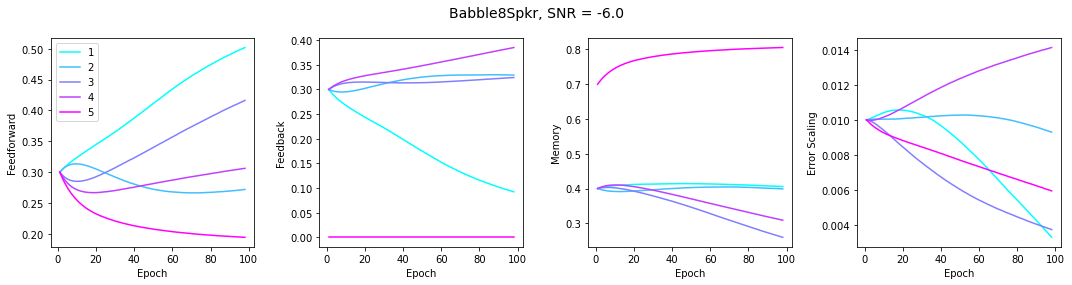




hyper_pinkNoise_snr3.0


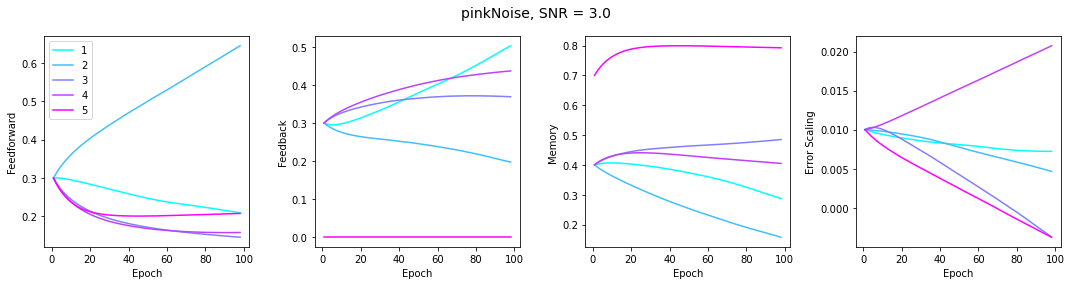




hyper_pinkNoise_snr-6.0


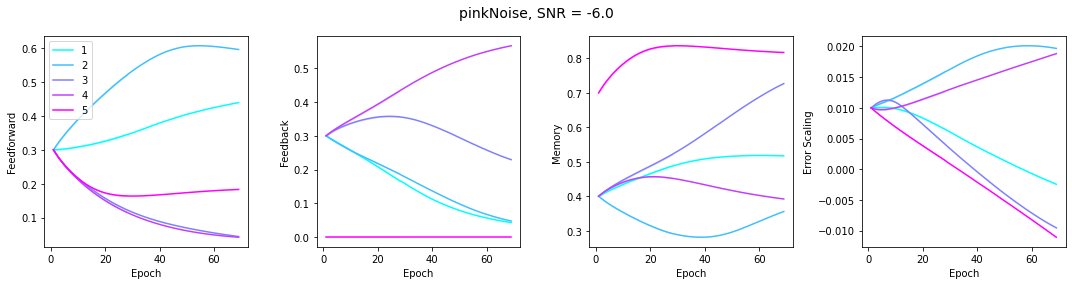




hyper_AudScene_snr-3.0


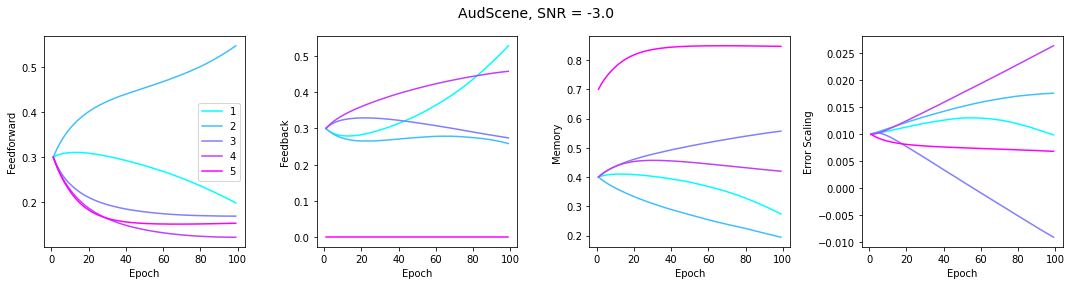




hyper_AudScene_snr0.0


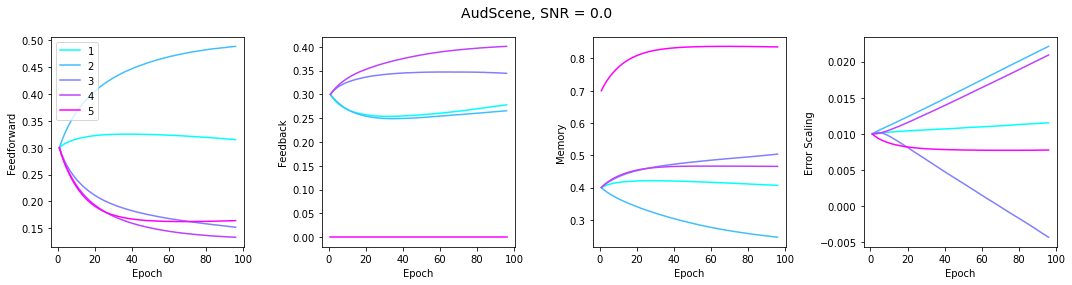




hyper_pinkNoise_snr-9.0


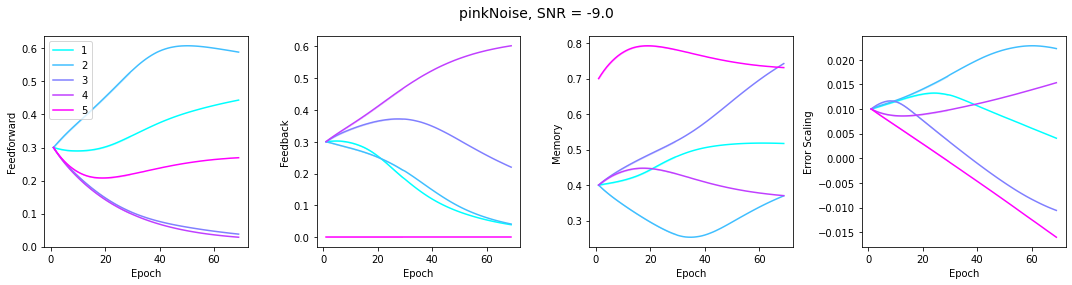




hyper_pinkNoise_snr0.0


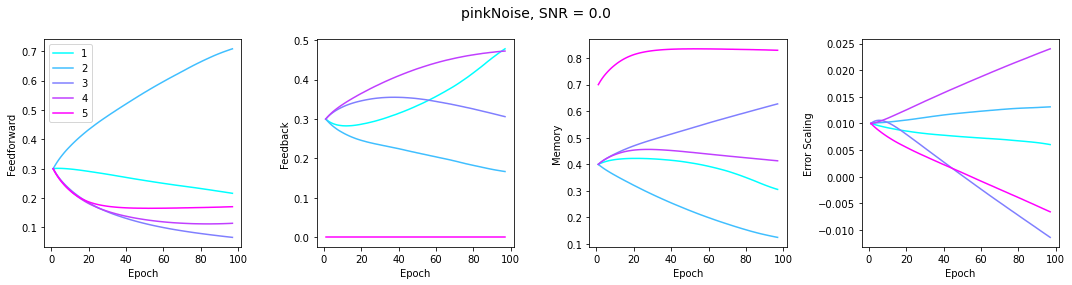




hyper_AudScene_snr-6.0


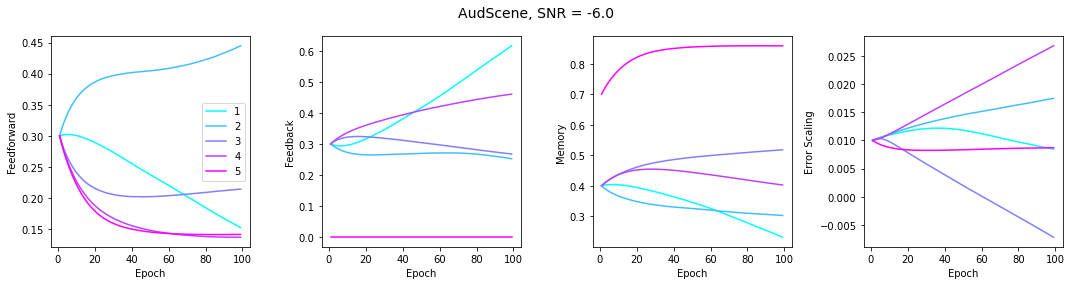




hyper_Babble8Spkr_snr-3.0


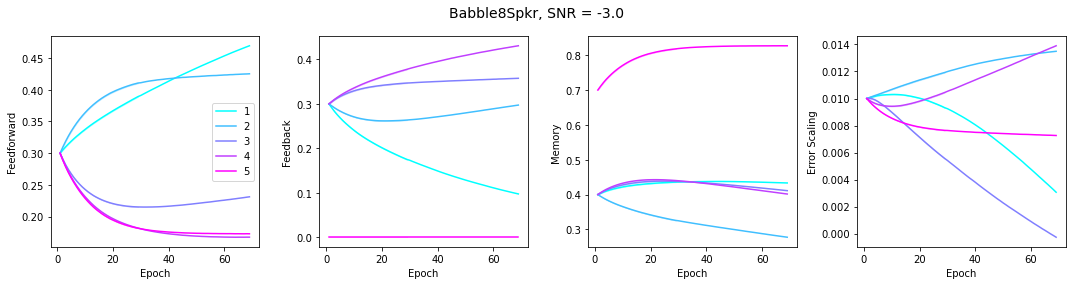




hyper_AudScene_snr3.0


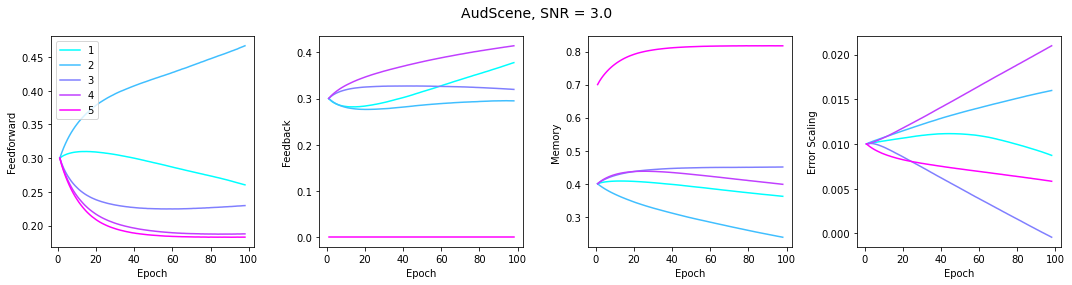




hyper_AudScene_snr-9.0


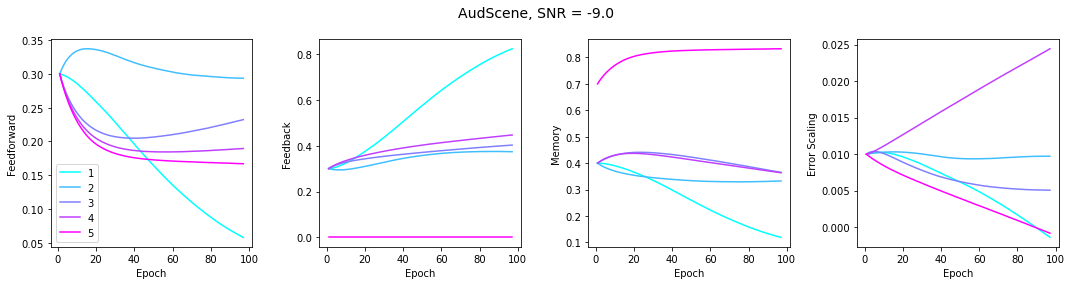




hyper_Babble8Spkr_snr3.0


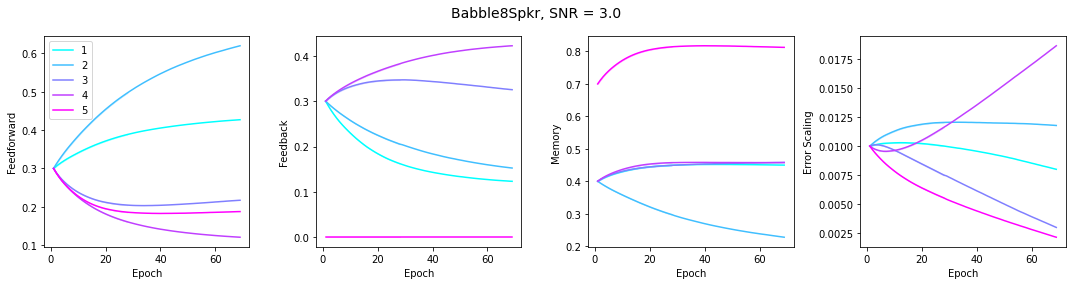




hyper_Babble8Spkr_snr-9.0


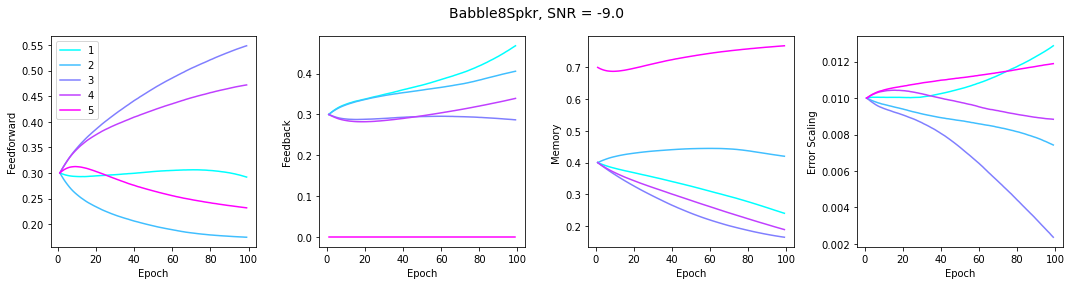




hyper_Babble8Spkr_snr0.0


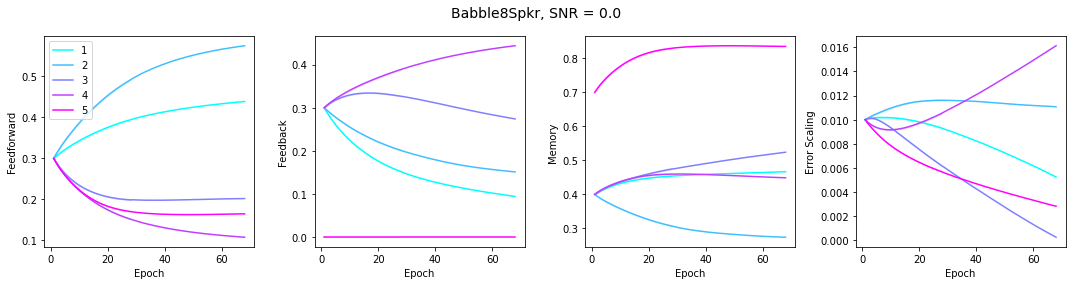




hyper_pinkNoise_snr-3.0


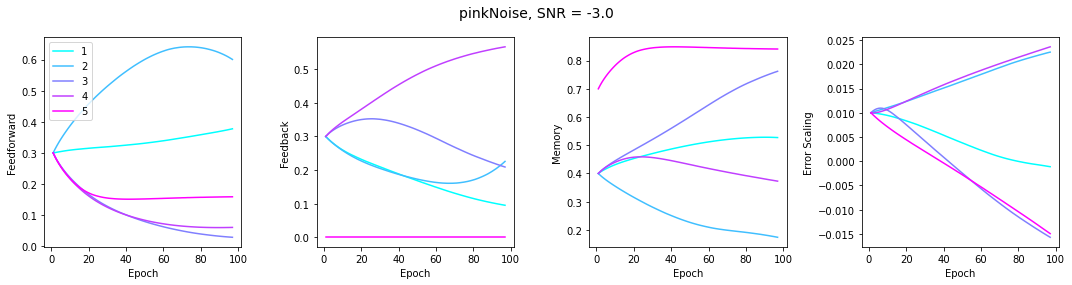

In [6]:
for tfdir in os.listdir(tensorboard_dir):
    if 'hyper' not in tfdir: continue
    if 'shared' in tfdir: continue
    if tfdir == 'small-hyper': continue
    print("====================")
    print(tfdir)
    print("====================")
    noise_info = tfdir.split('_')
    noise_snr = float(noise_info[-1][3:])
    noise_bg = noise_info[1]
    
    # Collect tensorboard files of interest
    tfdir = tensorboard_dir + tfdir + '/'
    tfdir_files = os.listdir(tfdir)
    if not plot_ci:
        if len(tfdir_files) > 1:
            print('More than one TF file; check it is correct.')
        tfdir_files = [tfdir_files[0]]
        
    # Collect hyperparameters
    feedforward = []
    feedback = []
    memory = []
    error_scaling = []
    layer = []
    epoch = []
    iteration = []
    
    for _iter, tfdir_file in enumerate(tfdir_files):
        tf_file = tfdir + tfdir_file
        ea = event_accumulator.EventAccumulator(tf_file)
        ea.Reload()
        for i in range(1, 6):
            try:
                _feedforward = [x.value for x in ea.Scalars(f"Hyperparam/pcoder{i}_feedforward")]
            except:
                continue
            _feedback = [x.value for x in ea.Scalars(f"Hyperparam/pcoder{i}_feedback")]
            _memory = [x.value for x in ea.Scalars(f"Hyperparam/pcoder{i}_memory")]
            _error_scaling = [x.value for x in ea.Scalars(f"Hyperparam/pcoder{i}_error")]
            feedforward.extend(_feedforward)
            feedback.extend(_feedback)
            memory.extend(_memory)
            error_scaling.extend(_error_scaling)
            layer.extend([i]*len(_feedforward))
            epoch.extend([e+1 for e in range(len(_feedforward))])
            iteration.extend([_iter]*len(_feedforward))

    # Make pandas dataframe
    df = pd.DataFrame({
        'Feedforward': feedforward,
        'Feedback': feedback,
        'Memory': memory,
        'Error Scaling': error_scaling,
        'Layer': layer,
        'Epoch': epoch,
        'Iteration': iteration
        })
    
    fig, axs = plt.subplots(1, 4, figsize = (15,4))
    colors = plt.cm.cool(np.linspace(0,1,5))
    for layer in range(1, 6):
        sns.lineplot(
            x='Epoch', y='Feedforward',
            color=colors[layer-1], ax=axs[0],
            data=df[df['Layer']==layer], label=layer
            )
        sns.lineplot(
            x='Epoch', y='Feedback',
            color=colors[layer-1], ax=axs[1],
            data=df[df['Layer']==layer]
            )
        sns.lineplot(
            x='Epoch', y='Memory',
            color=colors[layer-1], ax=axs[2],
            data=df[df['Layer']==layer]
            )
        sns.lineplot(
            x='Epoch', y='Error Scaling',
            color=colors[layer-1], ax=axs[3],
            data=df[df['Layer']==layer]
            )
    plt.suptitle(f'{noise_bg}, SNR = {noise_snr}', fontsize=14)
    plt.tight_layout()
    plt.show()
    print('\n\n')


In [11]:
# Collect hyperparameters
feedforward = []
feedback = []
memory = []
error_scaling = []
iteration = []
bg = []
snr = []
layers = []

for tfdir in os.listdir(tensorboard_dir):
    if 'hyper' not in tfdir: continue
    if 'shared' in tfdir: continue
    if tfdir == 'small-hyper': continue
    noise_info = tfdir.split('_')
    noise_snr = float(noise_info[-1][3:])
    noise_bg = noise_info[1]
    
    # Collect tensorboard files of interest
    tfdir = tensorboard_dir + tfdir + '/'
    tfdir_files = os.listdir(tfdir)
    if not plot_ci:
        if len(tfdir_files) > 1:
            print('More than one TF file; check it is correct.')
        tfdir_files = [tfdir_files[0]]
    
    for _iter, tfdir_file in enumerate(tfdir_files):
        tf_file = tfdir + tfdir_file
        ea = event_accumulator.EventAccumulator(tf_file)
        ea.Reload()
        try:
            _eval_acc = ea.Scalars(f'NoisyPerf/Epoch#60')[0].value
        except:
            continue
        
        for i in range(1, 6):
            _feedforward = [x.value for x in ea.Scalars(f"Hyperparam/pcoder{i}_feedforward")]
            _feedback = [x.value for x in ea.Scalars(f"Hyperparam/pcoder{i}_feedback")]
            _memory = [x.value for x in ea.Scalars(f"Hyperparam/pcoder{i}_memory")]
            _error_scaling = [x.value for x in ea.Scalars(f"Hyperparam/pcoder{i}_error")]
            
            feedforward.append(_feedforward[-1])
            feedback.append(_feedback[-1])
            memory.append(_memory[-1])
            error_scaling.append(_error_scaling[-1])
            iteration.append(_iter)
            bg.append(noise_bg)
            snr.append(noise_snr)
            layers.append(i)

    # Make pandas dataframe
    df = pd.DataFrame({
        'Feedforward': feedforward,
        'Feedback': feedback,
        'Memory': memory,
        'Error Scaling': error_scaling,
        'Background Noise': bg,
        'SNR': snr, 
        'Layer': layers
        })


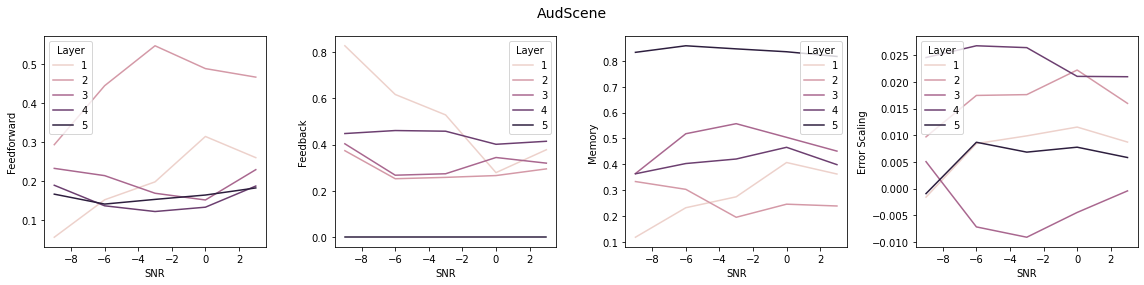

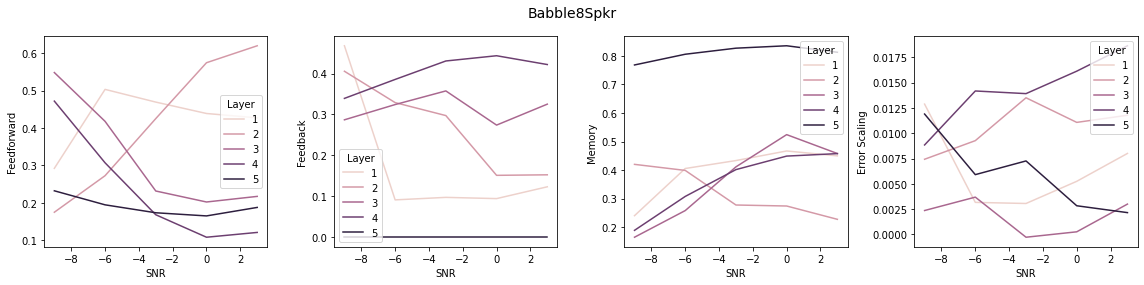

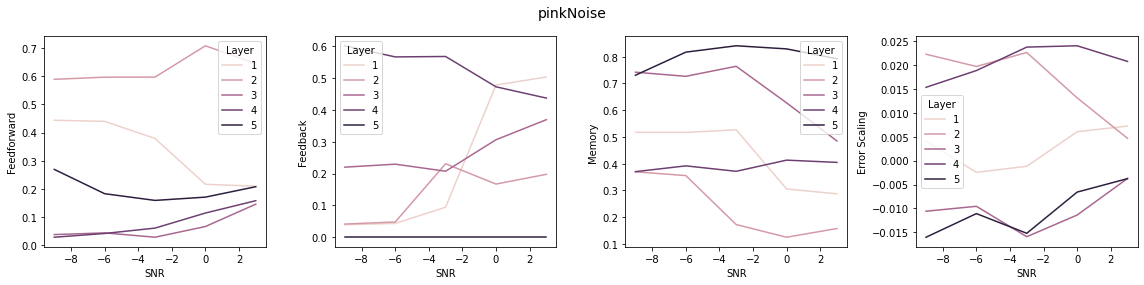

In [12]:
for _bg in np.unique(bg):
    fig, axs = plt.subplots(1, 4, figsize = (16,4))
    sns.lineplot(
        x='SNR', y='Feedforward', hue='Layer',
        ax=axs[0], data=df[df['Background Noise'] == _bg]
        )
    sns.lineplot(
        x='SNR', y='Feedback', hue='Layer',
        ax=axs[1], data=df[df['Background Noise'] == _bg]
        )
    sns.lineplot(
        x='SNR', y='Memory', hue='Layer',
        ax=axs[2], data=df[df['Background Noise'] == _bg]
        )
    sns.lineplot(
        x='SNR', y='Error Scaling', hue='Layer',
        ax=axs[3], data=df[df['Background Noise'] == _bg]
        )
    plt.suptitle(f'{_bg}', fontsize=14)
    plt.tight_layout()
    plt.show()
    print('\n\n')

# Shared Hyperparameters

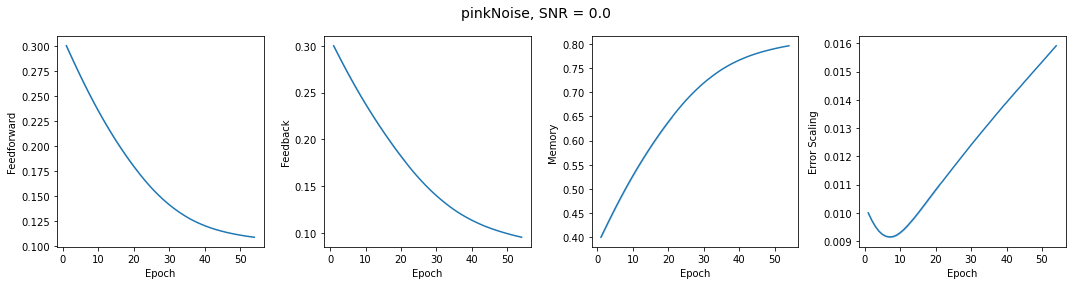

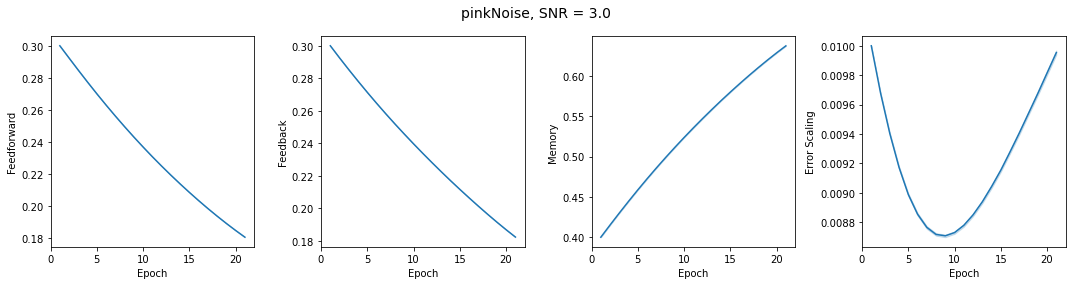

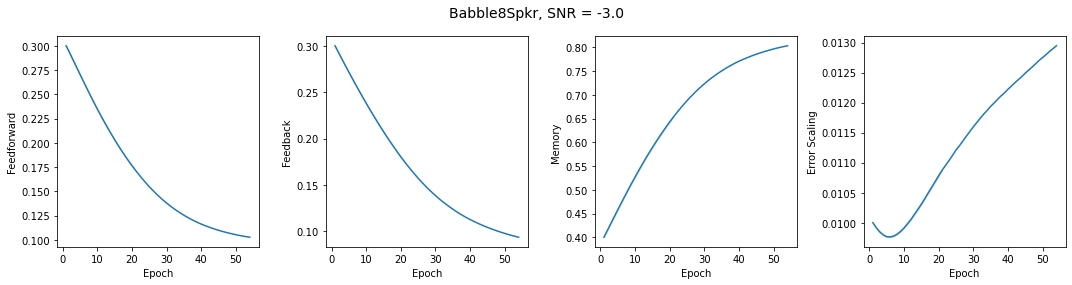

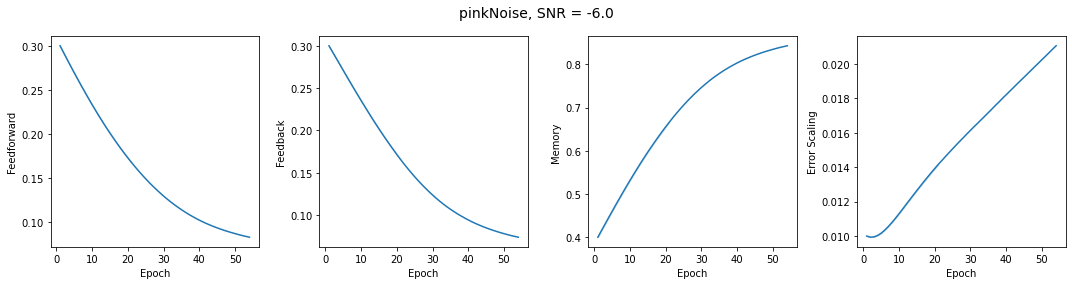

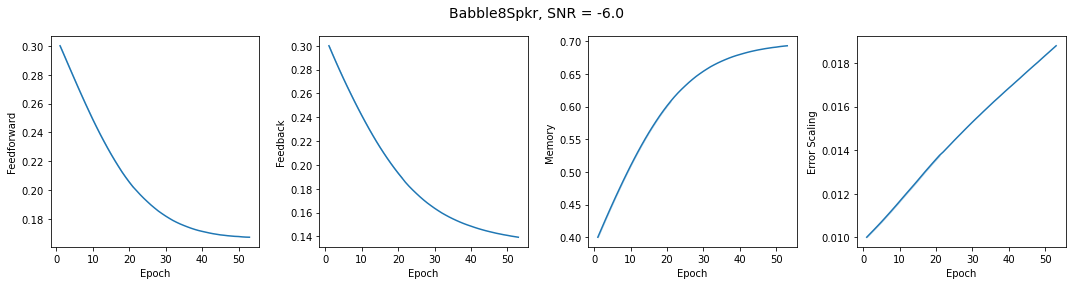

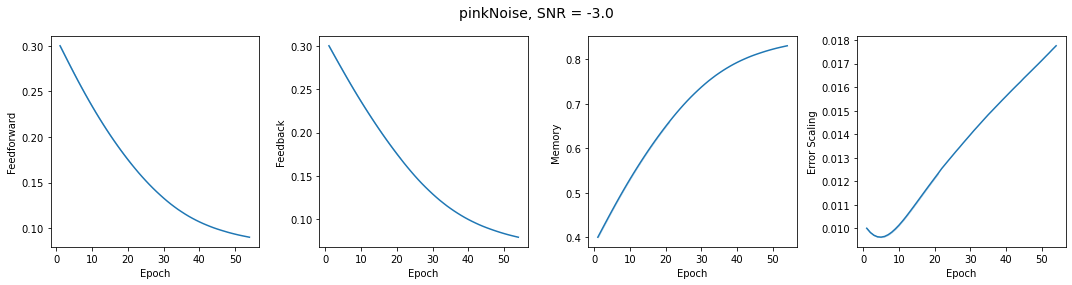

ValueError: arrays must all be same length

In [10]:
for tfdir in os.listdir(tensorboard_dir):
    if 'hyper' not in tfdir: continue
    if 'shared' not in tfdir: continue
    noise_info = tfdir.split('_')
    noise_snr = float(noise_info[-2][3:])
    noise_bg = noise_info[1]
    
    # Collect tensorboard files of interest
    tfdir = tensorboard_dir + tfdir + '/'
    tfdir_files = os.listdir(tfdir)
    if not plot_ci:
        if len(tfdir_files) > 1:
            print('More than one TF file; check it is correct.')
        tfdir_files = [tfdir_files[0]]
        
    # Collect hyperparameters
    feedforward = []
    feedback = []
    memory = []
    error_scaling = []
    epoch = []
    iteration = []
    
    for _iter, tfdir_file in enumerate(tfdir_files):
        tf_file = tfdir + tfdir_file
        ea = event_accumulator.EventAccumulator(tf_file)
        ea.Reload()
        try:
            _feedforward = [x.value for x in ea.Scalars(f"Hyperparam/feedforward")]
        except:
            continue
        _feedback = [x.value for x in ea.Scalars(f"Hyperparam/feedback")]
        _memory = [x.value for x in ea.Scalars(f"Hyperparam/memory")]
        _error_scaling = [x.value for x in ea.Scalars(f"Hyperparam/error")]
        feedforward.extend(_feedforward)
        feedback.extend(_feedback)
        memory.extend(_memory)
        error_scaling.extend(_error_scaling)
        epoch.extend([e+1 for e in range(len(_feedforward))])
        iteration.extend([_iter]*len(_feedforward))

    # Make pandas dataframe
    df = pd.DataFrame({
        'Feedforward': feedforward,
        'Feedback': feedback,
        'Memory': memory,
        'Error Scaling': error_scaling,
        'Epoch': epoch,
        'Iteration': iteration
        })
    
    fig, axs = plt.subplots(1, 4, figsize = (15,4))
    sns.lineplot(
        x='Epoch', y='Feedforward',
        ax=axs[0], data=df
        )
    sns.lineplot(
        x='Epoch', y='Feedback',
        ax=axs[1], data=df
        )
    sns.lineplot(
        x='Epoch', y='Memory',
        ax=axs[2], data=df
        )
    sns.lineplot(
        x='Epoch', y='Error Scaling',
        ax=axs[3], data=df
        )
    plt.suptitle(f'{noise_bg}, SNR = {noise_snr}', fontsize=14)
    plt.tight_layout()
    plt.show()
    print('\n\n')


In [ ]:
# Collect hyperparameters
feedforward = []
feedback = []
memory = []
error_scaling = []
iteration = []
bg = []
snr = []

for tfdir in os.listdir(tensorboard_dir):
    if 'hyper' not in tfdir: continue
    if 'shared' not in tfdir: continue
    noise_info = tfdir.split('_')
    noise_snr = float(noise_info[-2][3:])
    noise_bg = noise_info[1]
    
    # Collect tensorboard files of interest
    tfdir = tensorboard_dir + tfdir + '/'
    tfdir_files = os.listdir(tfdir)
    if not plot_ci:
        if len(tfdir_files) > 1:
            print('More than one TF file; check it is correct.')
        tfdir_files = [tfdir_files[0]]
    
    for _iter, tfdir_file in enumerate(tfdir_files):
        tf_file = tfdir + tfdir_file
        ea = event_accumulator.EventAccumulator(tf_file)
        ea.Reload()
        try:
            _feedforward = [x.value for x in ea.Scalars(f"Hyperparam/feedforward")]
        except:
            continue
        _feedback = [x.value for x in ea.Scalars(f"Hyperparam/feedback")]
        _memory = [x.value for x in ea.Scalars(f"Hyperparam/memory")]
        _error_scaling = [x.value for x in ea.Scalars(f"Hyperparam/error")]
        feedforward.append(_feedforward[-1])
        feedback.append(_feedback[-1])
        memory.append(_memory[-1])
        error_scaling.append(_error_scaling[-1])
        iteration.append(_iter)
        bg.append(noise_bg)
        snr.append(noise_snr)

    # Make pandas dataframe
    df = pd.DataFrame({
        'Feedforward': feedforward,
        'Feedback': feedback,
        'Memory': memory,
        'Error Scaling': error_scaling,
        'Background Noise': bg,
        'SNR': snr
        })


In [ ]:
for _bg in np.unique(bg):
    fig, axs = plt.subplots(1, 4, figsize = (15,4))
    sns.barplot(
        x='SNR', y='Feedforward',
        ax=axs[0], data=df[df['Background Noise'] == _bg]
        )
    sns.barplot(
        x='SNR', y='Feedback',
        ax=axs[1], data=df[df['Background Noise'] == _bg]
        )
    sns.barplot(
        x='SNR', y='Memory',
        ax=axs[2], data=df[df['Background Noise'] == _bg]
        )
    sns.barplot(
        x='SNR', y='Error Scaling',
        ax=axs[3], data=df[df['Background Noise'] == _bg]
        )
    plt.suptitle(f'{_bg}', fontsize=14)
    plt.tight_layout()
    plt.show()
    print('\n\n')